# 0. Pythonチュートリアル
## 0.0 Pythonの準備（ライブラリのインポート）

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## 0.1 スペクトル密度のグラフを描いてみる

Moku:LabでとったPSDデータをPythonで読んでグラフを描いてみます。

In [2]:
# Load data from csv file
data = np.loadtxt('FeedBack.csv',delimiter=',',comments='%')
freq = data[:,0]
ch1 = data[:,1]
ch2 = data[:,2]

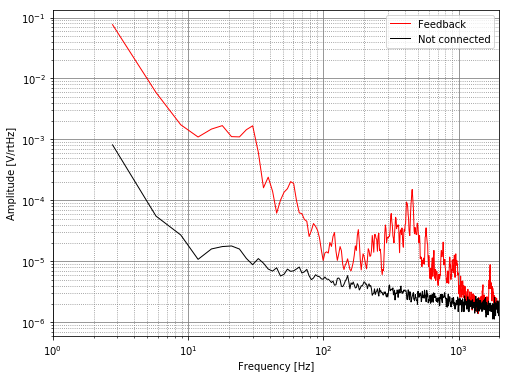

In [3]:
# Plot 
fig, (ax0) = plt.subplots(1,1,sharex=True,figsize=(8,6))    
ax0.loglog(freq,ch1,'r-',label='Feedback',linewidth=1)
ax0.loglog(freq,ch2,'k-',label='Not connected',linewidth=1)
ax0.grid(b=True, which='major', color='gray', linestyle='-')
ax0.grid(b=True, which='minor', color='gray', linestyle=':')
ax0.set_xlim(1,2000)
ax0.set_xlabel('Frequency [Hz]')
ax0.set_ylabel('Amplitude [V/rtHz]')
ax0.legend()

OK。描けた。

## 0.2 伝達関数を描いてみる

今度はBode図を描く。

In [4]:
data = np.loadtxt('OpenLoop.csv',delimiter=',',comments='%')
f = data[:,0]
#ch1_mag = data[:,1] # dB
#ch1_phase = data[:,2] # deg
#ch2_mag = data[:,3] # dB
#ch2_phase = data[:,4] # deg
tf12_mag = data[:,5] # dB
tf12_phase = data[:,6] # deg 

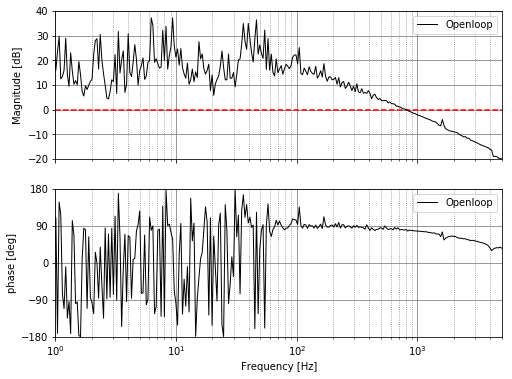

In [5]:
fig, (ax0,ax1) = plt.subplots(2,1,sharex=True, figsize=(8,6))    

# upper graph
ax0.semilogx(f,tf12_mag,'k-',label='Openloop',linewidth=1)
ax0.grid(b=True, which='major', color='gray', linestyle='-')
ax0.grid(b=True, which='minor', color='gray', linestyle=':')
ax0.set_xlim(1e0,5e3)
ax0.set_ylim(-20,40)
ax0.set_ylabel('Magnitude [dB]')
ax0.legend()    
ax0.hlines([0], 1e0, 5e3, "red", linestyles='--') # 0 dB line

# lower graph
ax1.semilogx(f,tf12_phase,'k-',label='Openloop',linewidth=1)    
ax1.grid(b=True, which='major', color='gray', linestyle='-')
ax1.grid(b=True, which='minor', color='gray', linestyle=':')
ax1.set_ylabel('phase [deg]')    
ax1.set_xlim(1e0,5e3)
ax1.set_xlabel('Frequency [Hz]')
ax1.set_yticks(np.arange(-180,181,90))
ax1.set_ylim(-180,180)
ax1.legend()

描けた。

# 1. 自作干渉計で地面振動を測定する
## 1.1 原理
### FeedBackなし
<img src="Pendulum.png" width=220>
図１：振り子

地面振動$x_0$から鏡の変位$x$までの伝達関数$H_0$は、
$$
H_0 = \frac{\frac{\omega_0}{Q}{s}+\omega_0}{s^2+\frac{\omega_0}{Q}{s}+\omega_0}
$$
である。
また$x_0$から地面との相対変位$d=x-x_0$までの伝達関数$H$は、$H=H_0-1$という関係より
$$
H = \frac{-s^2}{s^2+\frac{\omega_0}{Q}{s}+\omega_0}
$$
である。

これをもとにして地面振動と相対変位の関係をしらべてみる。

10Hz周辺にある共振よりも高周波では、鏡は防振されて$x = 0$なので、そのときの相対変位変位$d$は、
$$
d = x_0
$$
となる。一方で共振以下では、、鏡は防振されず$x = x_0$なので、そのときの変位$d$は、
$$
d = 0
$$
となる。したがって、フィードバックなしで地面振動をみようとすれば、共振以上でしか測定できない。



### FeedBackあり
<img src="BlockDiagram.png" width=420>
図2：ブロック図

フィードバックの目的は、入力値rと干渉計からの出力値yを等しくするようにすることである。そのようなフィードバックがかかれば、線形領域のせまい干渉計でも変位センサーとしてつかうことができる。

ここで、Aはアクチュエータ効率、Pは振り子の伝達関数、Dは干渉計の応答係数、Cは制御フィルターである。


ブロック図によれば、フィードバック信号は以下のように表すことができる。
$$
f = \frac{G}{1+G}r + \frac{G}{1+G} \frac{x_0}{A}
$$

一方で、エラー信号は以下の通り。
$$
y = \frac{1}{1+G}(DPAr) + \frac{1}{1+G}(DPx_0)
$$

さて、地面振動を測りたい。

**(1) OpenLoopが大きい場合（G>>1）**

十分にGが大きいとき、フィードバック信号は
$$f = r +\frac{x_0}{A}$$
となる。r はDC入力なので、我々が知りたい地面振動のAC成分だけを考える場合、無視できる。
よって地面振動は
$$x_0 = fA$$
で与えることができる。

**(2) OpenLoopが小さい場合（G<<1）**

Gが小さいとき、$f=0$になるので、フィードバック信号から地面振動を求めることはできない。このときは単純にエラー信号から求めることができる。つまり、Gが小さいときエラー信号は
$$ y = DPAr + DPx_0 $$
であり、先程と同様で、DCの入力成分は無視するので、エラー信号は
$$ y = DPx_0 $$
で与えられる。

## 1.2 測定